# Visual Odometry for Localization in Autonomous Driving

Welcome to the assignment for Module 2: Visual Features - Detection, Description and Matching. In this assignment, you will practice using the material you have learned to estimate an autonomous vehicle trajectory by images taken with a monocular camera set up on the vehicle.


**In this assignment, you will:**
- Extract  features from the photographs  taken with a camera setup on the vehicle.
- Use the extracted features to find matches between the features in different photographs.
- Use the found matches to estimate the camera motion between subsequent photographs. 
- Use the estimated camera motion to build the vehicle trajectory.

For most exercises, you are provided with a suggested outline. You are encouraged to diverge from the outline if you think there is a better, more efficient way to solve a problem.

You are only allowed to use the packages loaded bellow and the custom functions explained in the notebook. Run the cell bellow to import the required packages:

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
np.set_printoptions(threshold=np.nan)

## 0 - Loading and Visualizing the Data
We provide you with a convenient dataset handler class to read and iterate through samples taken from the CARLA simulator. Run the following code to create a dataset handler object. 

In [2]:
dataset_handler = DatasetHandler()

The dataset handler contains 52 data frames. Each frame contains an RGB image and a depth map taken with a setup on the vehicle and a grayscale version of the RGB image which will be used for computation. Furthermore, camera calibration matrix K is also provided in the dataset handler.

Upon creation of the dataset handler object, all the frames will be automatically read and loaded. The frame content can be accessed by using `images`, `images_rgb`, `depth_maps` attributes of the dataset handler object along with the index of the requested frame. See how to access the images (grayscale), rgb images (3-channel color), depth maps and camera calibration matrix in the example below.

**Note (Depth Maps)**: Maximum depth distance is 1000. This value of depth shows that the selected pixel is at least 1000m (1km) far from the camera, however the exact distance of this pixel from the camera is unknown. Having this kind of points in further trajectory estimation might affect the trajectory precision.

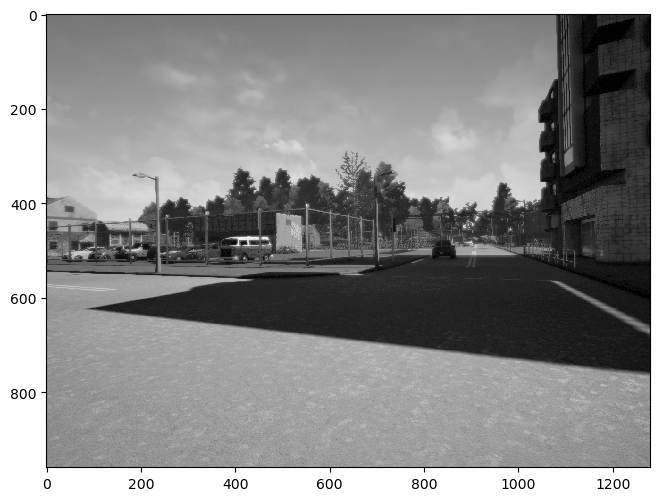

In [3]:
image = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

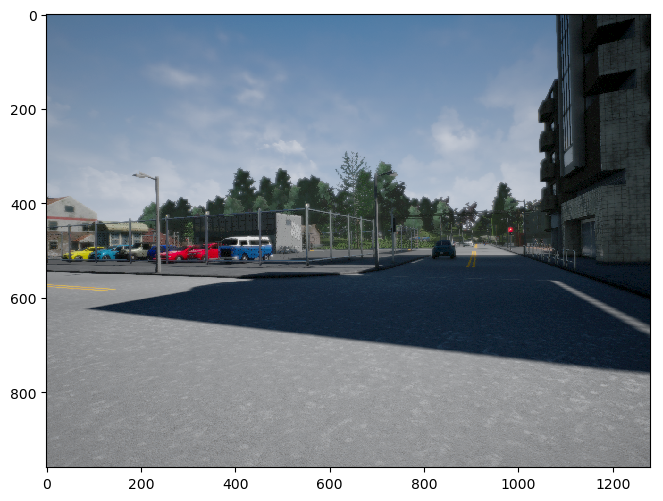

In [4]:
image_rgb = dataset_handler.images_rgb[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

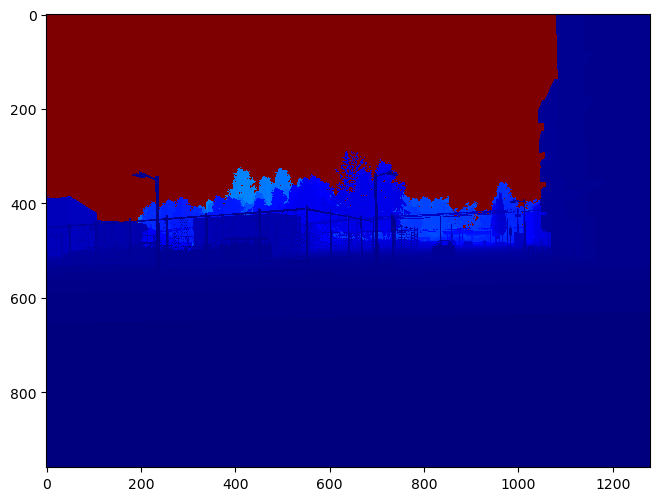

In [5]:
i = 0
depth = dataset_handler.depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

In [6]:
print("Depth map shape: {0}".format(depth.shape))

v, u = depth.shape
depth_val = depth[v-1, u-1]
print("Depth value of the very bottom-right pixel of depth map {0} is {1:0.3f}".format(i, depth_val))

Depth map shape: (960, 1280)
Depth value of the very bottom-right pixel of depth map 0 is 1.862


In [7]:
dataset_handler.k

array([[640.,   0., 640.],
       [  0., 480., 480.],
       [  0.,   0.,   1.]], dtype=float32)

In order to access an arbitrary frame use image index, as shown in the examples below. Make sure the indexes are within the number of frames in the dataset. The number of frames in the dataset can be accessed with num_frames attribute.

In [8]:
# Number of frames in the dataset
print(dataset_handler.num_frames)

52


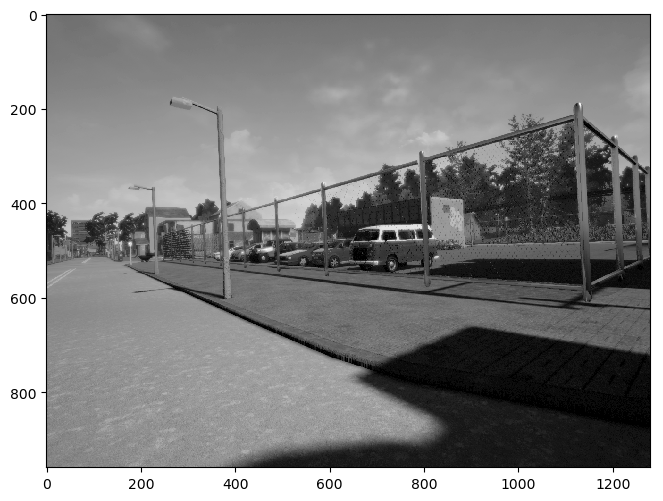

In [9]:
i = 30
image = dataset_handler.images[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

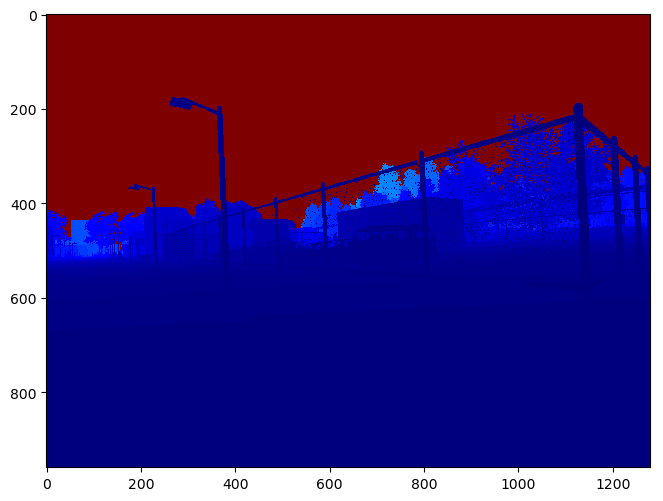

In [10]:
depth = dataset_handler.depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

## 1 - Feature Extraction

### 1.1 - Extracting Features from an Image

**Task**: Implement feature extraction from a single image. You can use any feature descriptor of your choice covered in the lectures, ORB for example. 


Note 1: Make sure you understand the structure of the keypoint descriptor object, this will be very useful for your further tasks. You might find [OpenCV: Keypoint Class Description](https://docs.opencv.org/3.4.3/d2/d29/classcv_1_1KeyPoint.html) handy.

Note 2: Make sure you understand the image coordinate system, namely the origin location and axis directions.

Note 3: We provide you with a function to visualise the features detected. Run the last 2 cells in section 1.1 to view.

***Optional***: Try to extract features with different descriptors such as SIFT, ORB, SURF and BRIEF. You can also try using detectors such as Harris corners or FAST and pairing them with a descriptor. Lastly, try changing parameters of the algorithms. Do you see the difference in various approaches?
You might find this link useful:  [OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html). 

In [11]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    ### START CODE HERE ### 
    orb = cv.ORB_create(nfeatures =1000)
    kp = orb.detect(image, None)
    kp, des = orb.compute(image, kp)
    ### END CODE HERE ###
    
    return kp, des

In [12]:
i = 0
image = dataset_handler.images[i]
kp, des = extract_features(image)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

Number of features detected in frame 0: 1000

Coordinates of the first keypoint in frame 0: (832.0, 391.0)


In [13]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None)
    plt.imshow(display)

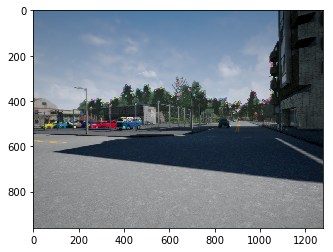

In [14]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image = dataset_handler.images_rgb[i]

visualize_features(image, kp)

### 1.2 - Extracting Features from Each Image in the Dataset

**Task**: Implement feature extraction for each image in the dataset with the function you wrote in the above section. 

**Note**: If you do not remember how to pass functions as arguments, make sure to brush up on this topic. This [
Passing Functions as Arguments](https://www.coursera.org/lecture/program-code/passing-functions-as-arguments-hnmqD) might be helpful.

In [15]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
    
    ### START CODE HERE ###
    for image in images:
        kp, des = extract_features(image)
        kp_list.append(kp)
        des_list.append(des)
    ### END CODE HERE ###
    
    return kp_list, des_list

In [16]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Length of images array: {0}".format(len(images)))

Number of features detected in frame 0: 1000
Coordinates of the first keypoint in frame 0: (832.0, 391.0)

Length of images array: 52


## 2 - Feature Matching

Next step after extracting the features in each image is matching the features from the subsequent frames. This is what is needed to be done in this section.

### 2.1 - Matching Features from a Pair of Subsequent Frames

**Task**: Implement feature matching for a pair of images. You can use any feature matching algorithm of your choice covered in the lectures, Brute Force Matching or FLANN based Matching for example.

***Optional 1***: Implement match filtering by thresholding the distance between the best matches. This might be useful for improving your overall trajectory estimation results. Recall that you have an option of specifying the number best matches to be returned by the matcher.

We have provided a visualization of the found matches. Do all the matches look legitimate to you? Do you think match filtering can improve the situation?

In [17]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    ### START CODE HERE ###
    FLANN_INDEX_LSH = 6
    index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    ### END CODE HERE ###

    return matches

In [18]:
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))

# Remember that a matcher finds the best matches for EACH descriptor from a query set

Number of features matched in frames 0 and 1: 1000


In [23]:
# Optional
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    #filtered_match = []
    
    ### START CODE HERE ###
    filtered_match = [f[0] for f in match if f[0].distance / f[1].distance < dist_threshold]  
    ### END CODE HERE ###

    return filtered_match

In [24]:
# Optional
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)

dist_threshold = 0.6
filtered_match = filter_matches_distance(match, dist_threshold)

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

Number of features matched in frames 0 and 1 after filtering by distance: 407


In [25]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    good = [[m] for m, n in match if m.distance < 0.7*n.distance]
    image_matches = cv2.drawMatchesKnn(image1, kp1, image2, kp2, good, None,
                              matchColor=(0, 255, 0), matchesMask=None,
                              singlePointColor=(255, 0, 0), flags=0)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

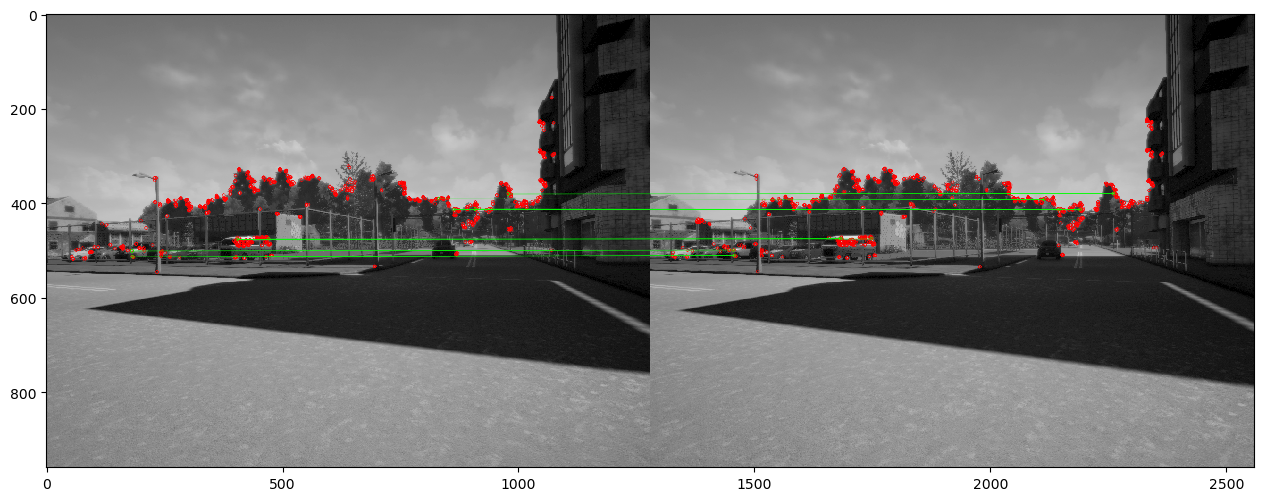

In [26]:
# Visualize n first matches, set n to None to view all matches
# set filtering to True if using match filtering, otherwise set to False
n = 20
filtering = False

i = 0 
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 0.6
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])    

### 2.2 - Matching Features in Each Subsequent Image Pair in the Dataset

**Task**: Implement feature matching for each subsequent image pair in the dataset with the function you wrote in the above section.

***Optional***: Implement match filtering by thresholding the distance for each subsequent image pair in the dataset with the function you wrote in the above section.

In [27]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    
    ### START CODE HERE ###
    des1 = des_list[i]
    des2 = des_list[i+1]
    match = match_features(des1, des2)

    #dist_threshold = 0.6
    #filtered_match = filter_matches_distance(match, dist_threshold)
    matches.append(match)
    
    ### END CODE HERE ###
    
    return matches

In [28]:
matches = match_features_dataset(des_list, match_features)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 0 and 1: 1000


In [29]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    ### START CODE HERE ###
    for match in matches:
        filtered_match = filter_matches_distance(match, dist_threshold)
        filtered_matches.append(filtered_match)

    
    ### END CODE HERE ###
    
    return filtered_matches

In [30]:
# Optional
dist_threshold = 0.6

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

Number of filtered matches in frames 0 and 1: 416


## 3 - Trajectory Estimation

At this point you have everything to perform visual odometry for the autonomous vehicle. In this section you will incrementally estimate the pose of the vehicle by examining the changes that motion induces on the images of its onboard camera.

### 3.1 - Estimating Camera Motion between a Pair of Images

**Task**: Implement camera motion estimation from a pair of images. You can use the motion estimation algorithm covered in the lecture materials, namely Perspective-n-Point (PnP), as well as Essential Matrix Decomposition.

- If you decide to use PnP, you will need depth maps of frame and they are provided with the dataset handler. Check out Section 0 of this assignment to recall how to access them if you need. As this method has been covered in the course, review the lecture materials if need be.
- If you decide to use Essential Matrix Decomposition, more information about this method can be found in [Wikipedia: Determining R and t from E](https://en.wikipedia.org/wiki/Essential_matrix).

More information on both approaches implementation can be found in [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html). Specifically, you might be interested in _Detailed Description_ section of [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html) as it explains the connection between the 3D world coordinate system and the 2D image coordinate system.


***Optional***: Implement camera motion estimation with PnP, PnP with RANSAC and Essential Matrix Decomposition. Check out how filtering matches by distance changes estimated camera movement. Do you see the difference in various approaches?

In [ ]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    ### START CODE HERE ###
  

    
    ### END CODE HERE ###
    
    return rmat, tvec, image1_points, image2_points

In [ ]:
i = 0
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

**Expected Output Format**:

Make sure that your estimated rotation matrix and translation vector are in the same format as the given initial values

```
rmat = np.eye(3)
tvec = np.zeros((3, 1))

print("Initial rotation:\n {0}".format(rmat))
print("Initial translation:\n {0}".format(tvec))
```


```
Initial rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Initial translation:
 [[0.]
 [0.]
 [0.]]
```

**Camera Movement Visualization**:
You can use `visualize_camera_movement` that is provided to you. This function visualizes final image matches from an image pair connected with an arrow corresponding to direction of camera movement (when `is_show_img_after_mov = False`). The function description:
```
Arguments:
image1 -- the first image in a matched image pair (RGB or grayscale)
image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
image2 -- the second image in a matched image pair (RGB or grayscale)
image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
is_show_img_after_mov -- a boolean variable, controling the output (read image_move description for more info) 

Returns:
image_move -- an image with the visualization. When is_show_img_after_mov=False then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image
```

In [ ]:
i=30
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

In [ ]:
image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move=True)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)
# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

### 3.2 - Camera Trajectory Estimation

**Task**: Implement camera trajectory estimation with visual odometry. More specifically, implement camera motion estimation for each subsequent image pair in the dataset with the function you wrote in the above section.

***Note***: Do not forget that the image pairs are not independent one to each other. i-th and (i + 1)-th image pairs have an image in common

In [ ]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
    trajectory = np.zeros((3, 1))
    
    ### START CODE HERE ###
     
        
        
    ### END CODE HERE ###
    
    return trajectory

In [ ]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)

i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

**Expected Output**:

```
Camera location in point i is: 
 [[locXi]
 [locYi]
 [locZi]]```
 
 In this output: locXi, locYi, locZi are the coordinates of the corresponding i-th camera location

## 4 - Submission:

Evaluation of this assignment is based on the estimated trajectory from the output of the cell below.
Please run the cell bellow, then copy its output to the provided yaml file for submission on the programming assignment page.

**Expected Submission Format**:

```
Trajectory X:
 [[  0.          locX1        locX2        ...   ]]
Trajectory Y:
 [[  0.          locY1        locY2        ...   ]]
Trajectory Z:
 [[  0.          locZ1        locZ2        ...   ]]
```
 
 In this output: locX1, locY1, locZ1; locX2, locY2, locZ2; ... are the coordinates of the corresponding 1st, 2nd and etc. camera locations

In [ ]:
# Note: Make sure to uncomment the below line if you modified the original data in any ways
#dataset_handler = DatasetHandler()


# Part 1. Features Extraction
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)


# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 0.75
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches

    
# Part III. Trajectory Estimation
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)


#!!! Make sure you don't modify the output in any way
# Print Submission Info
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

### Visualize your Results

**Important**:

1) Make sure your results visualization is appealing before submitting your results. You might want to download this project dataset and check whether the trajectory that you have estimated is consistent to the one that you see from the dataset frames. 

2) Assure that your trajectory axis directions follow the ones in _Detailed Description_ section of [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html).

In [ ]:
visualize_trajectory(trajectory)

Congrats on finishing this assignment! 